In [1]:
import findspark
from pyspark.sql import SparkSession

findspark.init()

spark = SparkSession.builder \
        .master("local[*]") \
        .appName("agente") \
        .getOrCreate()

from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyspark.ml.feature import Normalizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA as PCAml
import networkx as nx

from sklearn import preprocessing
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = spark.read.csv('previsaodeacoes.csv', inferSchema=True, header=True)
dataset = pd.read_csv('previsaodeacoes.csv')

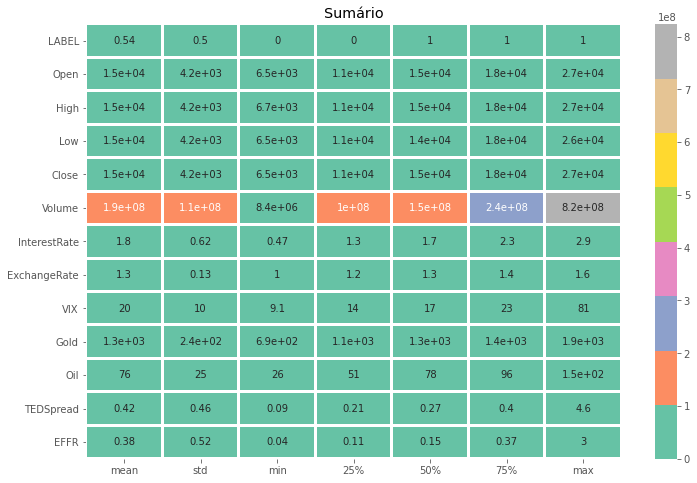

In [3]:
plt.figure(figsize=(12,8))
sns.heatmap(dataset.describe()[1:].transpose(),
            annot=True,linecolor="w",
            linewidth=2,cmap=sns.color_palette("Set2"))
plt.title("Sumário")
plt.show()

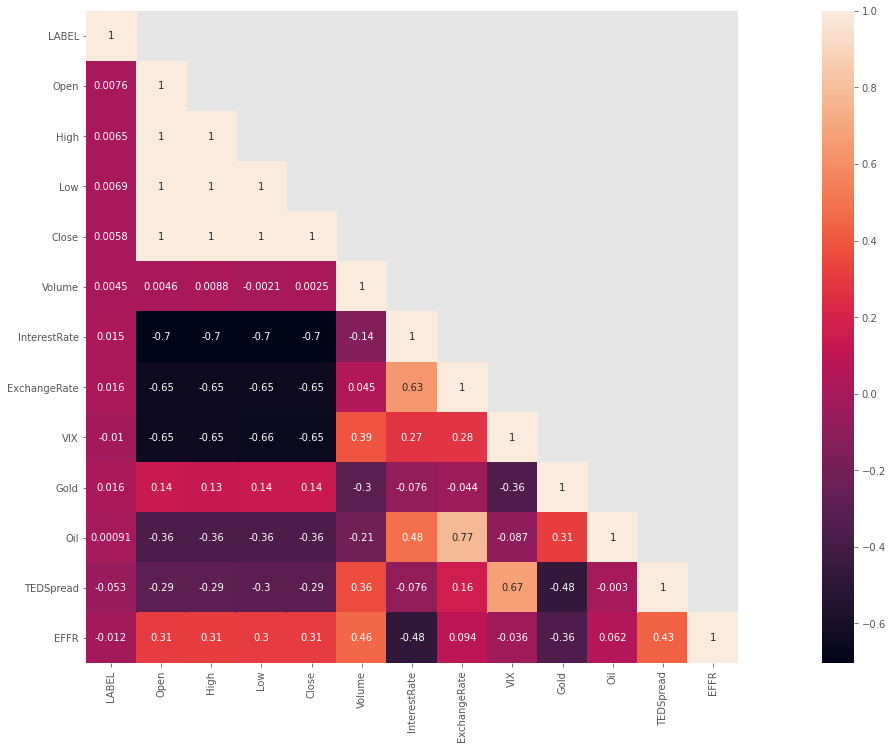

In [4]:
cor_mat= dataset[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)
plt.show()

In [5]:
corr=dataset.corr()
corr.sort_values(by=["LABEL"],ascending=False).iloc[0].sort_values(ascending=False)

LABEL           1.000000
Gold            0.015902
ExchangeRate    0.015507
InterestRate    0.014556
Open            0.007586
Low             0.006912
High            0.006496
Close           0.005817
Volume          0.004489
Oil             0.000909
VIX            -0.010016
EFFR           -0.012059
TEDSpread      -0.053203
Name: LABEL, dtype: float64

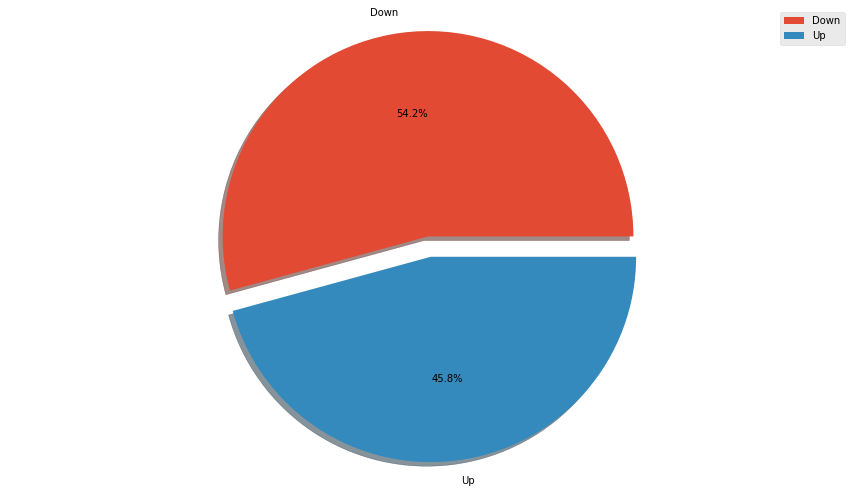

In [6]:
explode = (0.1,0)  
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.pie(dataset['LABEL'].value_counts(), explode=explode,labels=['Down','Up'], autopct='%1.1f%%',
        shadow=True)
ax1.axis('equal')  
plt.tight_layout()
plt.legend()
plt.show()

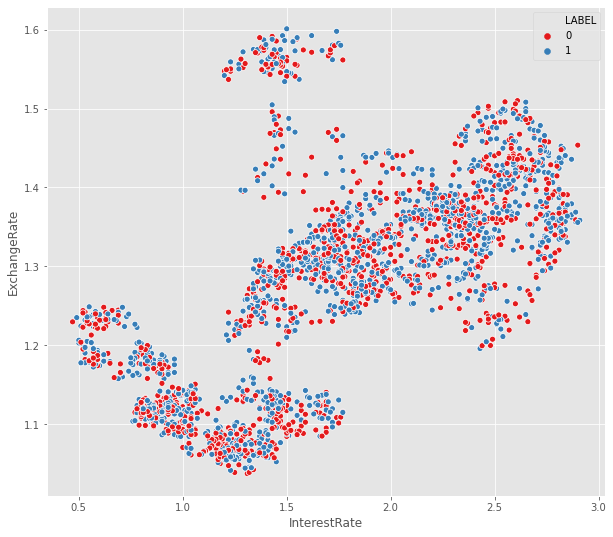

In [7]:
plt.figure(figsize=(10,9))
sns.scatterplot(x='InterestRate',y='ExchangeRate',data=dataset,palette='Set1', hue = 'LABEL');
plt.show()

In [8]:
def pre_processamento(df):
    #df = spark.read.csv('previsaodeacoes.csv', inferSchema=True, header=True)
    class_indexer = StringIndexer(inputCol="LABEL", outputCol="label")
    df = class_indexer.fit(df).transform(df)
    return df
    pass

In [9]:
def transformColumnsToNumeric(df, inputCol):
    
    inputCol_indexer = StringIndexer(inputCol = inputCol, outputCol = inputCol + "-index").fit(df)
    df = inputCol_indexer.transform(df)
    
    onehotencoder_vector = OneHotEncoder(inputCol = inputCol + "-index", outputCol = inputCol + "-vector")
    df = onehotencoder_vector.fit(df).transform(df)
    
    return df
    pass

In [10]:
def sensor(df, dataset):
    df = pre_processamento(df)
    
    df = transformColumnsToNumeric (df, "Open") 
    df = transformColumnsToNumeric (df, "High") 
    df = transformColumnsToNumeric (df, "Low") 
    df = transformColumnsToNumeric (df,  "Close")
    df = transformColumnsToNumeric (df, "Volume") 
    df = transformColumnsToNumeric (df, "InterestRate") 
    df = transformColumnsToNumeric (df, "ExchangeRate")
    df = transformColumnsToNumeric (df, "VIX") 
    df = transformColumnsToNumeric (df, "Gold") 
    df = transformColumnsToNumeric (df, "Oil") 
    df = transformColumnsToNumeric (df, "TEDSpread") 
    df = transformColumnsToNumeric (df, "EFFR")  

    inputCols=[
        'Open',
        'High', 
        'Low',	
        'Close',	
        'Volume',	
        'InterestRate',	
        'ExchangeRate',	
        'VIX',	
        'Gold',	
        'Oil',	
        'TEDSpread',	
        'EFFR']

    feature_columns = [
        'Open',
        'High', 
        'Low',	
        'Close',	
        'Volume',	
        'InterestRate',	
        'ExchangeRate',	
        'VIX',	
        'Gold',	
        'Oil',	
        'TEDSpread',	
        'EFFR']

    X = dataset[feature_columns].values
    y = dataset['LABEL'].values
    df_va = VectorAssembler(inputCols = inputCols, outputCol="features")
    df = df_va.transform(df)
    df_transformed = df.select(['features','label'])
    df_transformedreg = df.select(['features','close'])
    
    train_df, test_df = df_transformed.randomSplit([0.75,0.25])
    train_dfreg, test_dfreg = df_transformedreg.randomSplit([0.75,0.25])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
    
    return train_dfreg, test_dfreg, df_transformed, train_df, test_df,  X_train, X_test, y_train, y_test
    pass

def atuador(trained_model, test_df):
    classificacoes = trained_model.transform(test_df)
    classificacoes = np.array(classificacoes.select("prediction").collect())
    recomenda = 0
    naorecomenda = 0
    
    for c in classificacoes:
        if (c == 1):
            recomenda = recomenda + 1
        else:    
            naorecomenda = naorecomenda + 1

    print("%d situações recomendadas para manter ou comprar." % recomenda)
    print("%d situações recomendadas para vender." % naorecomenda)     
    
def atuadorknn(classifier, test_df):
    classificacoes = classifier.predict(X_test)
    recomenda = 0
    naorecomenda = 0
    
    for c in classificacoes:
        if (c == 1):
            recomenda = recomenda + 1
        else:    
            naorecomenda = naorecomenda + 1

    print("%d situações recomendadas para manter ou comprar." % recomenda)
    print("%d situações recomendadas para vender." % naorecomenda)

In [11]:
def arvoredecisaoRegressao(train_df, test_df):
    model = DecisionTreeRegressor(labelCol='close', featuresCol='features')
    trained_model = model.fit(train_df)

    test_predictions = trained_model.transform(test_df)

    real = np.array(test_df.select("close").collect())
    predito = np.array(test_predictions.select("prediction").collect())

    RMSE = mean_squared_error(real, predito, squared=False)
    print("RMSE = %f" % RMSE)

    MAE = mean_absolute_error(real, predito)
    print("MAE = %f" % MAE)
    
    plt.plot(real, color='blue')
    plt.plot(predito, color='red')
    plt.title('Regressão Árvore de Decisão')
    #plt.show()
    #plt.savefig("regressao1.png")

In [12]:
def florestaaleatoriaRegressao(train_df, test_df):
    model = RandomForestRegressor(labelCol='close', featuresCol='features')
    trained_model = model.fit(train_df)

    test_predictions = trained_model.transform(test_df)

    real = np.array(test_df.select("close").collect())
    predito = np.array(test_predictions.select("prediction").collect())

    RMSE = mean_squared_error(real, predito, squared=False)
    print("RMSE = %f" % RMSE)

    MAE = mean_absolute_error(real, predito)
    print("MAE = %f" % MAE)
    
    plt.plot(real, color='blue')
    plt.plot(predito, color='red')
    plt.title('Regressão Floresta Aleatória')
    #plt.show()
    plt.savefig("regressao2.png")

In [13]:
def arvoredecisao(train_df, test_df):
    model = DecisionTreeClassifier(labelCol='label', featuresCol='features')
    trained_model = model.fit(train_df)
    test_predictions = trained_model.transform(test_df)
    atuador(trained_model, test_df)
    return test_predictions

In [14]:
def naivebayes(train_df, test_df):
    model = NaiveBayes(labelCol='label')
    trained_model = model.fit(train_df)
    test_predictions = trained_model.transform(test_df)
    atuador(trained_model, test_df)
    return test_predictions

In [15]:
def logisticregression(train_df, test_df):
    model = LogisticRegression(maxIter=100)
    trained_model = model.fit(train_df)
    test_predictions = trained_model.transform(test_df)
    atuador(trained_model, test_df)
    return test_predictions

In [16]:
def knn(X_train, y_train):
    classifier = KNeighborsClassifier(n_neighbors=2)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    atuadorknn(classifier, y_train)
    
    accuracy_knn = accuracy_score(y_test, y_pred)*100
    print("Acurácia = = %3.1f %%" % accuracy_knn)
    return y_pred

In [17]:
def predicoes(test_predictions):
    test_df_count_1 = test_df.filter(test_df['label'] == 1).count()
    test_df_count_0 = test_df.filter(test_df['label'] == 0).count()
    test_df_count_1, test_df_count_0
        
    fp = test_predictions.filter(test_predictions['label'] == 0).filter(
    test_predictions['prediction'] == 1).select(
    ['label','prediction','probability'])
    print("Falsos positivos: ", fp.count())
        
    fn = test_predictions.filter(
    test_predictions['label'] == 1).filter(
    test_predictions['prediction'] == 0).select(
    ['label','prediction','probability'])
    print("Falsos negativos: ", fn.count())
        
    predictionAndLabels = test_predictions.select("prediction", "label")
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
    print("Acurácia = " + str(evaluator.evaluate(predictionAndLabels)))
    
    real = np.array(test_df.select("label").collect())
    predito = np.array(test_predictions.select("prediction").collect())
    
    return real, predito

In [18]:
def matriz_confusao(real, predito):
    cm = confusion_matrix(real, predito)
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="RdGy" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Matriz de confusão', y=1.1)
    plt.ylabel('Label real')
    plt.xlabel('Label predita')
    plt.show()

In [19]:
def matriz_confusaoknn(real, predito):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="RdGy" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Matriz de confusão', y=1.1)
    plt.ylabel('Label real')
    plt.xlabel('Label predita')
    plt.show()

In [20]:
def criafiguragrafo(G, corr_direction, min_correlation):
    H = G.copy()
    
    for stock1, stock2, weight in G.edges(data=True):
        if corr_direction == "positive":
            if weight["weight"] <0 or weight["weight"] < min_correlation:
                H.remove_edge(stock1, stock2)
        else:
            if weight["weight"] >=0 or weight["weight"] > min_correlation:
                H.remove_edge(stock1, stock2)
                
    
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    
    weights = tuple([(1+abs(x))**2 for x in weights])
    
    d = nx.degree(H)
    nodelist, node_sizes = zip(*dict(d).items())

    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(15,15))

    nx.draw_networkx_nodes(H,positions,node_color='#DA70D6',nodelist=nodelist,
                           node_size=tuple([x**3 for x in node_sizes]),alpha=0.8)
    
    nx.draw_networkx_labels(H, positions, font_size=8, 
                            font_family='sans-serif')
    
    if corr_direction == "positive":
        edge_colour = plt.cm.GnBu 
    else:
        edge_colour = plt.cm.PuRd
        
    nx.draw_networkx_edges(H, positions, edgelist=edges,style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))

    plt.axis('off')
    plt.show()

In [21]:
def PCA(df_transformed):
    kcomp = 2

    pca = PCAml(k=kcomp, inputCol="features", outputCol="pca")
    model = pca.fit(df_transformed)
    transformed = model.transform(df_transformed)
    transformed.printSchema()

    pca_var= np.round(100.00*model.explainedVariance.toArray(),kcomp)
    exvar_pca = sum(model.explainedVariance)

    print(pca_var)

    result = model.transform(df_transformed).select("pca")
    result.show(truncate=False)

    colname = [] 
    for i in range(1, kcomp+1):
        colname.append("PC"+str(i))

    name = colname
    values = pca_var 

    fig, ax = plt.subplots(figsize=(9, 3), sharey=True)
    ax.bar(name, values)
    fig.suptitle('Relevancia de cada componente')
    plt.plot()

In [22]:
train_dfreg, test_dfreg, df_transformed, train_df, test_df, X_train, X_test, y_train, y_test = sensor(df, dataset)

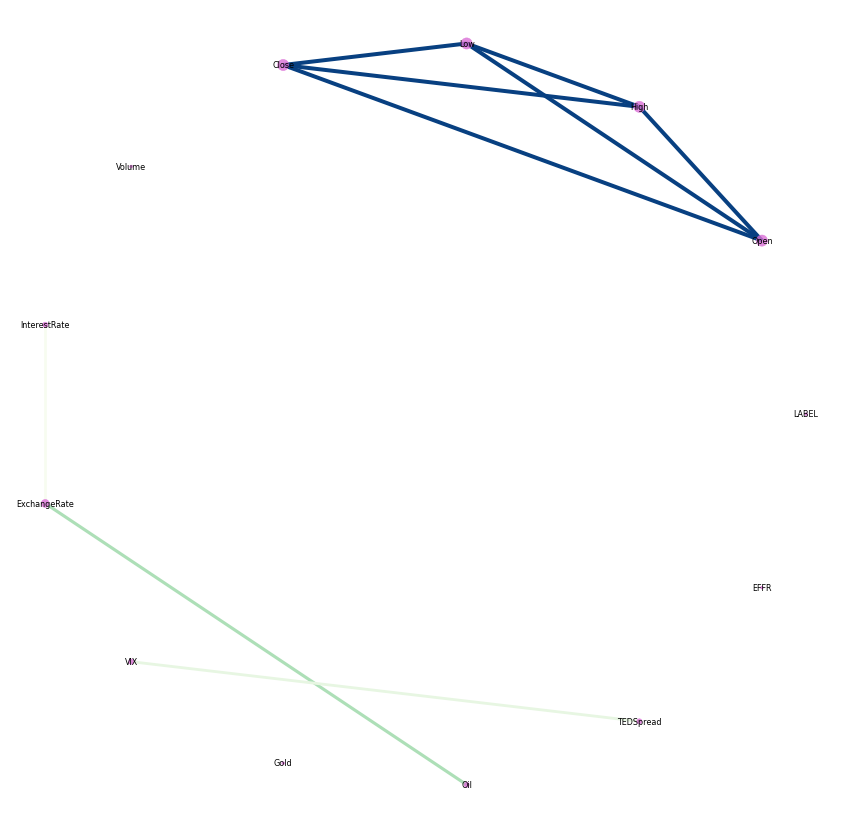

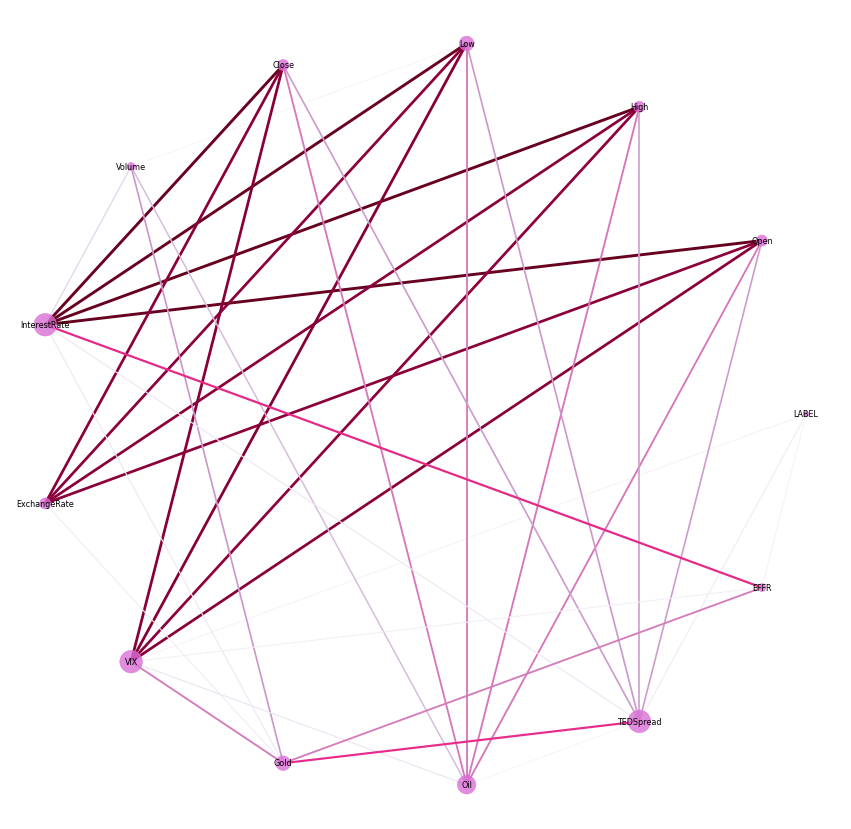

In [23]:
stocks = cor_mat.index.values

cor_matrix = np.asmatrix(cor_mat)
G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: stocks[x])
G.edges(data=True)

criafiguragrafo(G, "positive", 0.5)
criafiguragrafo(G, "negative", 0.5)

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- pca: vector (nullable = true)

[100.   0.]
+-------------------------------------------+
|pca                                        |
+-------------------------------------------+
|[-2.9553000000598913E8,-24849.183523763088]|
|[-2.3276000000606304E8,-25198.09829572037] |
|[-1.8387000000606307E8,-25172.277211076904]|
|[-1.8126000000606558E8,-25181.65978197754] |
|[-1.9807000000606298E8,-25222.229451806445]|
|[-1.9720000000601587E8,-25107.63174614895] |
|[-1.949500000060255E8,-25048.24383251444]  |
|[-2.2733000000600168E8,-25071.30063873098] |
|[-2.8685000000596696E8,-24821.703114451277]|
|[-2.1601000000587568E8,-24584.000923696465]|
|[-2.0895000000587785E8,-24609.54428307632] |
|[-2.69490000005968E8,-24926.587558473508]  |
|[-2.1700000000601E8,-25175.301491209742]   |
|[-3.0403000000608855E8,-25421.95190756491] |
|[-1.9240000000615215E8,-25591.75258076199] |
|[-2.149500000061264E8,-25460.35196751700

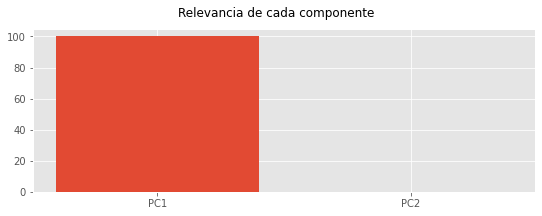

In [24]:
PCA(df_transformed)

238 situações recomendadas para manter ou comprar.
367 situações recomendadas para vender.
Falsos positivos:  121
Falsos negativos:  176
Acurácia = 0.509090909090909


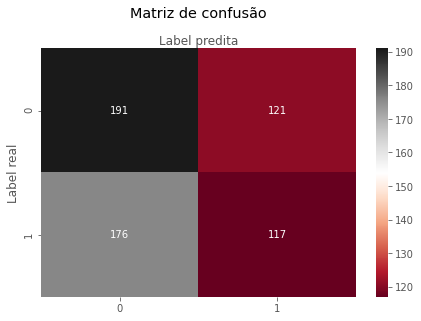

In [25]:
test_predictions = arvoredecisao(train_df, test_df)
real, predito = predicoes(test_predictions)
matriz_confusao(real, predito)

331 situações recomendadas para manter ou comprar.
274 situações recomendadas para vender.
Falsos positivos:  171
Falsos negativos:  133
Acurácia = 0.4975206611570248


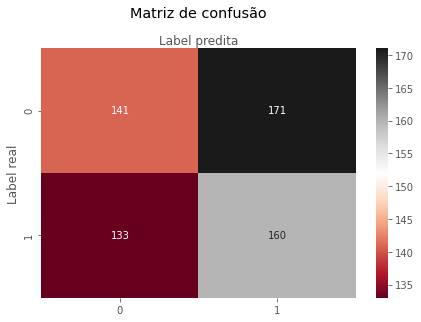

In [26]:
test_predictions = naivebayes(train_df, test_df)
real, predito = predicoes(test_predictions)
matriz_confusao(real, predito)

101 situações recomendadas para manter ou comprar.
504 situações recomendadas para vender.
Falsos positivos:  49
Falsos negativos:  241
Acurácia = 0.5206611570247934


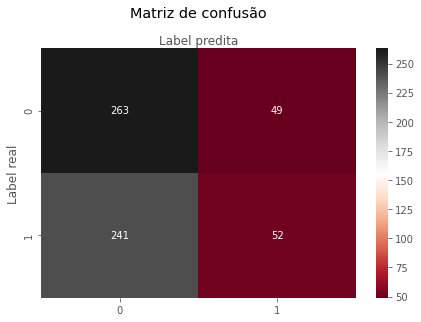

In [27]:
test_predictions = logisticregression(train_df, test_df)
real, predito = predicoes(test_predictions)
matriz_confusao(real, predito)

176 situações recomendadas para manter ou comprar.
436 situações recomendadas para vender.
Acurácia = = 48.5 %


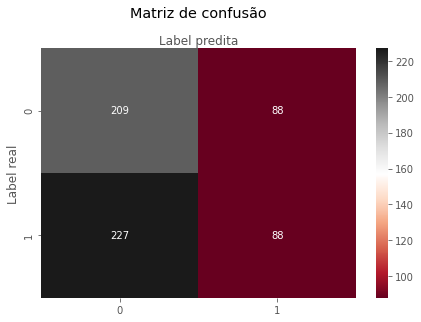

In [28]:
y_pred = knn(X_train, y_train)
matriz_confusao(y_test, y_pred)

RMSE = 229.088993
MAE = 162.953967


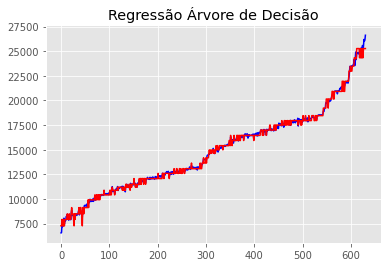

In [29]:
arvoredecisaoRegressao(train_dfreg, test_dfreg)

RMSE = 186.383964
MAE = 123.798429


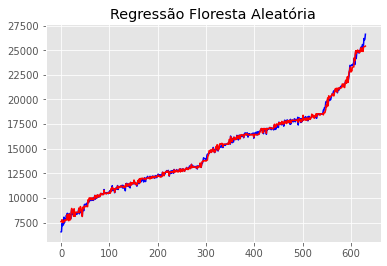

In [31]:
florestaaleatoriaRegressao(train_dfreg, test_dfreg)